## Twitter disaster prediction

### Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from wordcloud import WordCloud

from tensorflow.keras. preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, SpatialDropout1D

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [7]:
df['location'].value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [8]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

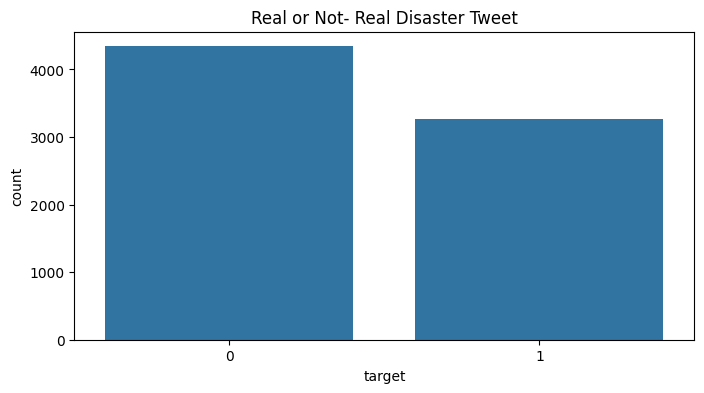

In [9]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df)
plt.title('Real or Not- Real Disaster Tweet')
plt.show()

<Axes: ylabel='target'>

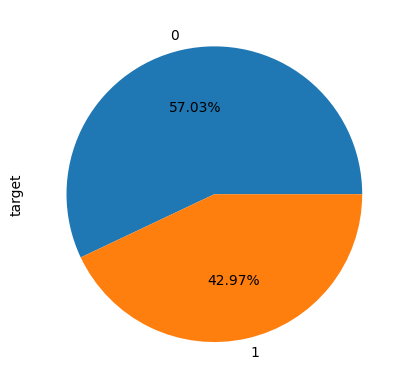

In [10]:
df['target'].value_counts().plot.pie(autopct='%1.2f%%')

In [11]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-ae4l2c42
  Running command git clone --filter=blob:none --quiet https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-ae4l2c42
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 96bf02872d9756f29d6cddb8aafaedcd2a39bbb4
  Preparing metadata (setup.py) ... done
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7602 sha256=a1561b889d8dbadd3aa8e2bbab011fb4d9f569411bd6a83aa07b9fd42a234f63
  Stored in directory: /tmp/pip-ephem-wheel-cache-f6y6417q/wheels/5c/94/34/99d5ff65e88b8d9a6c5e8d8652f2311d87790a61a1b7466e21
Successfully built preprocess-kgptalkie


In [12]:
import preprocess_kgptalkie as kgp

In [13]:
tweet = kgp.get_basic_features(df)
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


<Axes: xlabel='char_counts', ylabel='Count'>

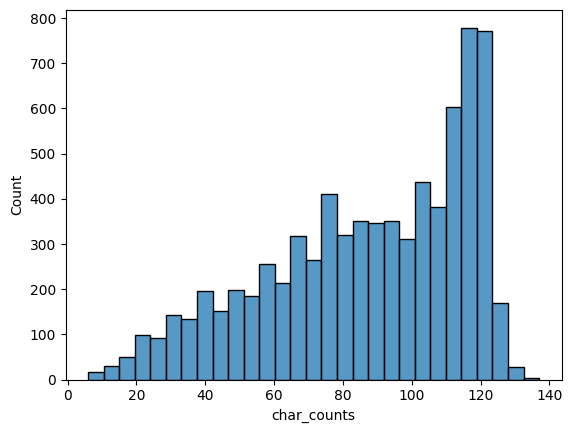

In [14]:
sns.histplot(data=tweet, x='char_counts')

<Axes: xlabel='char_counts', ylabel='Density'>

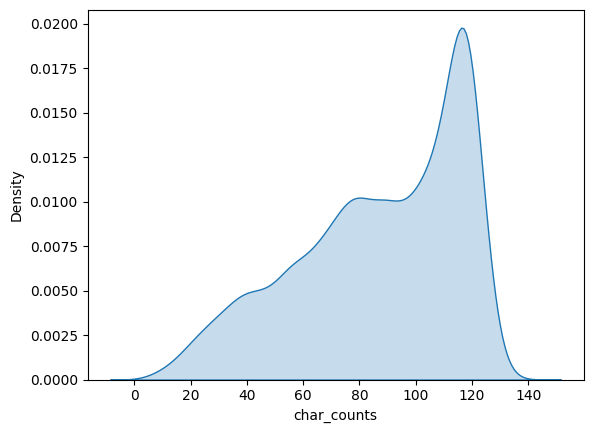

In [15]:

# Create a kernel density estimation plot for the 'char_counts' column
sns.kdeplot(data=tweet, x='char_counts', fill=True)

<Axes: xlabel='char_counts', ylabel='Density'>

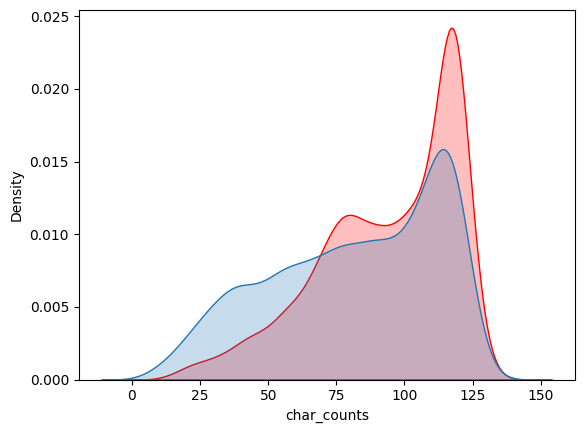

In [16]:
# Create a kernel density estimation plot for the 'char_counts' column for tweets with target=1
sns.kdeplot(data=tweet[tweet['target']==1], x='char_counts', fill=True, color='red')

# Create a kernel density estimation plot for the 'char_counts' column for tweets with target=0
sns.kdeplot(data=tweet[tweet['target']==0], x='char_counts', fill=True)

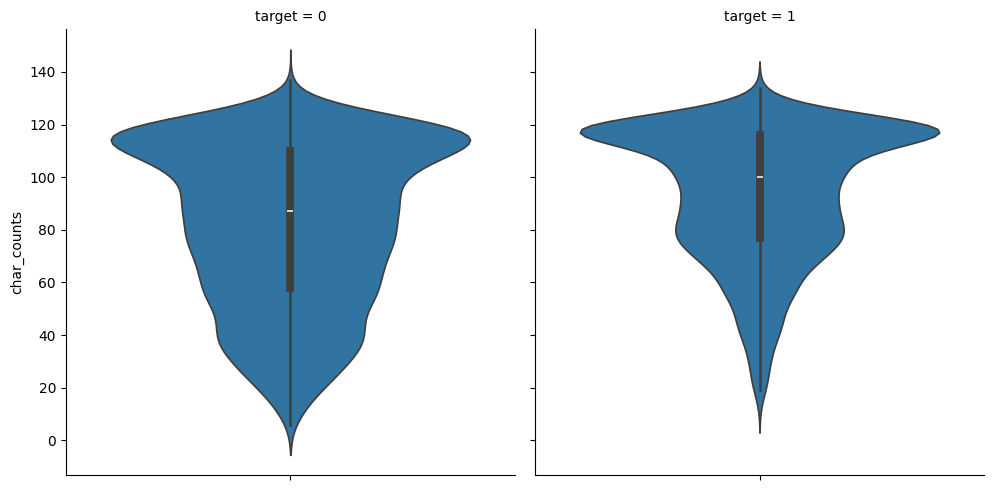

In [17]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

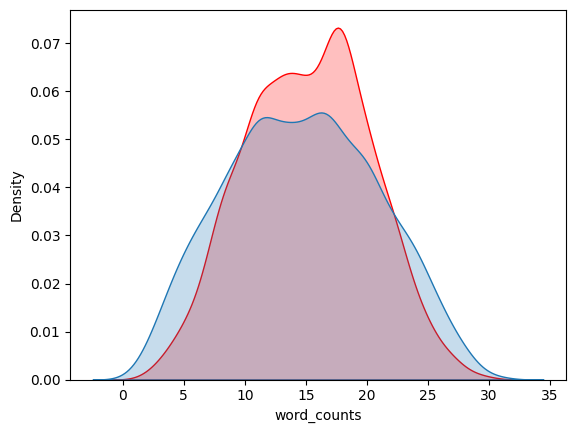

In [18]:
# Create a kernel density estimation plot for the 'word_counts' column for tweets with target=1
sns.kdeplot(data=tweet[tweet['target']==1], x='word_counts', fill=True, color='red')

# Create a kernel density estimation plot for the 'word_counts' column for tweets with target=0
sns.kdeplot(data=tweet[tweet['target']==0], x='word_counts', fill=True)

# Show the plot
plt.show()

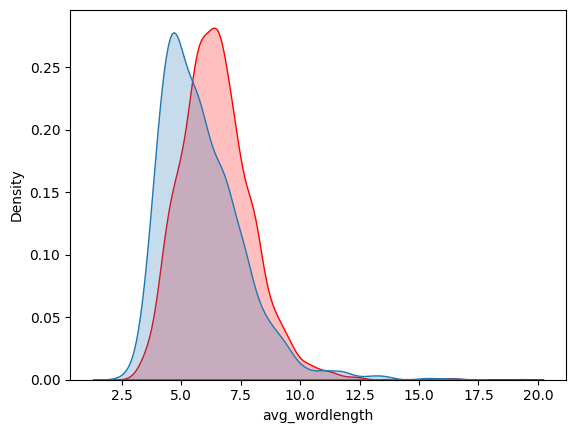

In [19]:
# Create a kernel density estimation plot for the 'avg_wordlength' column for tweets with target=1
sns.kdeplot(data=tweet[tweet['target']==1], x='avg_wordlength', fill=True, color='red')

# Create a kernel density estimation plot for the 'avg_wordlength' column for tweets with target=0
sns.kdeplot(data=tweet[tweet['target']==0], x='avg_wordlength', fill=True)

# Show the plot
plt.show()

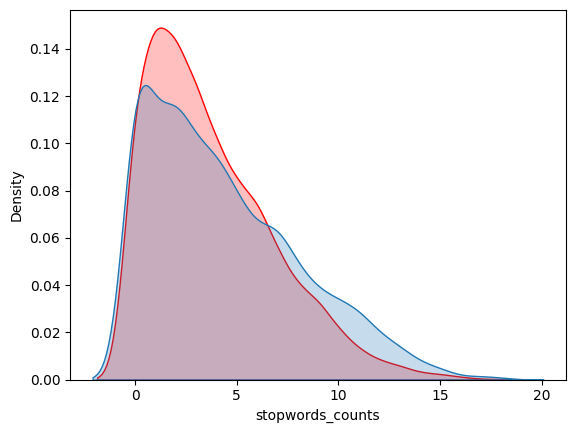

In [20]:
# Create a kernel density estimation plot for the 'stopwords_counts' column for tweets with target=1
sns.kdeplot(data=tweet[tweet['target']==1], x='stopwords_counts', fill=True, color='red')

# Create a kernel density estimation plot for the 'stopwords_counts' column for tweets with target=0
sns.kdeplot(data=tweet[tweet['target']==0], x='stopwords_counts', fill=True)

# Show the plot
plt.show()

In [21]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

Common Words , The most and least

In [22]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [24]:
top20 = freqs[100:120]
top20

back         85
see          85
@YouTube     82
go           81
3            81
Is           80
RT           80
THE          80
time         80
disaster     78
think        77
buildings    76
Full         76
bomb         75
suicide      74
want         73
body         73
Emergency    73
How          72
down         72
dtype: int64

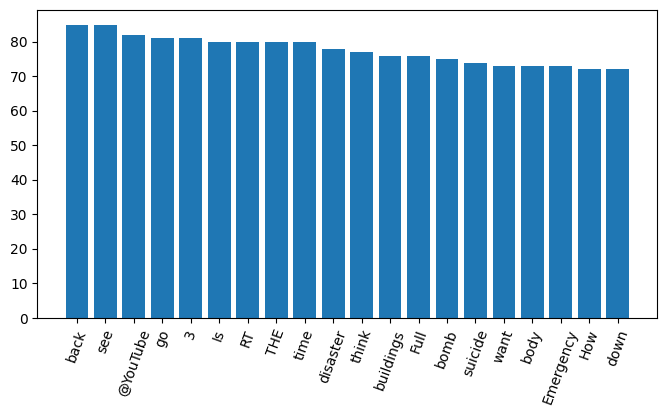

In [25]:
plt.figure(figsize=(8,4))
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [26]:
least20 = freqs[-20:]
least20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
dtype: int64

In [28]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

###One-Shot Data Cleaning

In [29]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [30]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

/usr/local/lib/python3.10/dist-packages/preprocess_kgptalkie/utils.py:97: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(x, 'lxml').get_text().strip()


In [32]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0


In [33]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

### Disaster Words Visualization with Word Cloud



In [34]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

'httpt the in of a to and is on for i at by from it that with not you after this fire are was as have my news httpst over up more via disaster an were be people california suicide has no police who but when been killed like do 2 will just hiroshima than so out fires storm crash families we train now about into emergency s your buildings bomb there all what two mh370 attack am nuclear they wildfire video accident get new one bombing how prime minister northern burning legionnaires dead me bomber homes some if car war still atomic obama he fatal years off may us collapse forest retweet city watch debris malaysia first today 1 japan or man latest mass severe near water had earthquake before those confirmed found oil would down 70 spill floods army world home under warning 4 could injured wreckage weather derailment outbreak 3 evacuation being saudi thunderstorm migrants 40 our old flood missing flooding can during say investigators their time bridge back mosque death suspect state her cha

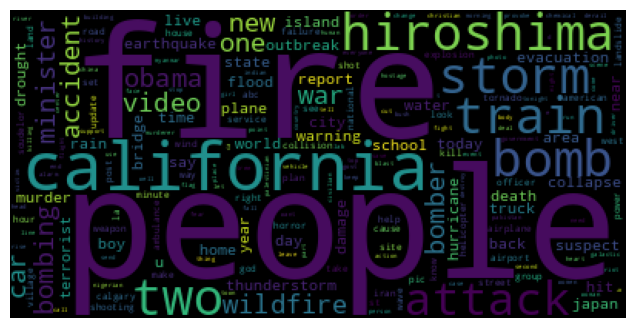

In [35]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.figure(figsize=(8,4))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

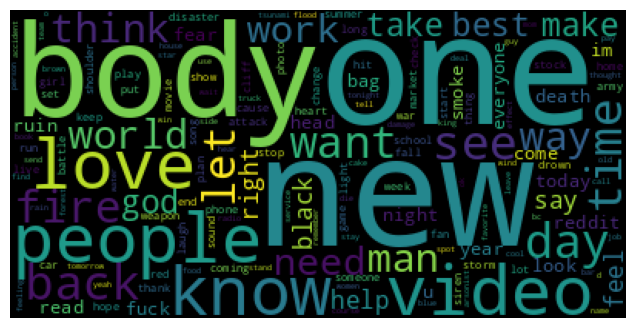

In [36]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.figure(figsize=(8,4))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Preprocessing

In [38]:
text=tweet['text']

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

y = tweet['target']
X.shape, y.shape

((7613, 22545), (7613,))

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [40]:
X_train.shape, X_test.shape

((6090, 22545), (1523, 22545))

MODEL SVM

In [41]:
from sklearn.svm import LinearSVC

In [42]:
clf=LinearSVC()

clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



Model Word2Vec and SVM

In [43]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [44]:
import spacy
import en_core_web_lg

In [45]:
nlp = en_core_web_lg.load()

In [46]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [48]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.8476947, 0.8888447, -3.10391, 0.090650745,..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.35491997, -1.5415528, -2.0926642, -0.49523..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[-2.8959212, 0.6998072, -2.5640087, 1.2561336,..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-2.3889112, -0.6061475, -2.453201, 1.5150287,..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.8628482, -0.2587669, -2.5594664, 0.3031685..."


In [49]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [50]:
X.shape

(7613, 1)

In [51]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [52]:
X.shape

(7613, 300)

In [53]:
y = tweet['target']

In [54]:
X.shape, y.shape

((7613, 300), (7613,))

In [55]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [56]:
clf = LinearSVC()

clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       869
           1       0.71      0.73      0.72       654

    accuracy                           0.76      1523
   macro avg       0.75      0.76      0.75      1523
weighted avg       0.76      0.76      0.76      1523



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Word Embeddings and Classification with Deep Learning

In [57]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [58]:
token = Tokenizer()
token.fit_on_texts(text)

In [59]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [60]:
print(token.word_index)

{'httpt': 1, 'the': 2, 'a': 3, 'in': 4, 'to': 5, 'of': 6, 'i': 7, 'and': 8, 'is': 9, 'you': 10, 'for': 11, 'on': 12, 'it': 13, 'my': 14, 'not': 15, 'that': 16, 'with': 17, 'at': 18, 'by': 19, 'this': 20, 'have': 21, 'are': 22, 'from': 23, 'be': 24, 'was': 25, 'httpst': 26, 'do': 27, 'like': 28, 'as': 29, 'out': 30, 'am': 31, 'so': 32, 'your': 33, 'up': 34, 'me': 35, 'just': 36, 'but': 37, 'will': 38, 'after': 39, 'has': 40, 'all': 41, 'no': 42, 'fire': 43, 'an': 44, 'when': 45, 'if': 46, 'he': 47, 'new': 48, 'we': 49, 'get': 50, 'they': 51, 'now': 52, 'about': 53, 'via': 54, 'more': 55, 'people': 56, 'what': 57, 'or': 58, 'how': 59, 'one': 60, 'been': 61, 'there': 62, '2': 63, 'over': 64, 'news': 65, 'would': 66, 'who': 67, 'into': 68, 'were': 69, 'video': 70, 'can': 71, 'emergency': 72, 'disaster': 73, 'us': 74, 'police': 75, 'than': 76, 'off': 77, 'her': 78, 'some': 79, 'still': 80, 'his': 81, 'body': 82, 'back': 83, 'time': 84, 'burning': 85, 'california': 86, 'crash': 87, 'know': 8

In [61]:
encoded_text = token.texts_to_sequences(text)
print(encoded_text)

[[109, 4491, 22, 2, 868, 6, 20, 246, 129, 1681, 4492, 74, 41], [186, 43, 223, 763, 6792, 6793, 1328], [41, 1682, 1435, 5, 2062, 4, 655, 22, 125, 6794, 19, 1683, 42, 438, 253, 58, 2062, 4, 655, 1329, 22, 1054], [2809, 56, 4493, 1330, 253, 1329, 4, 86], [36, 93, 1159, 20, 314, 23, 6795, 2063, 29, 261, 23, 1330, 6796, 68, 3, 189], [2810, 391, 86, 1554, 793, 829, 4, 637, 6797, 534, 5, 1106, 372, 43, 4494, 1330], [224, 73, 830, 282, 1160, 831, 247, 6, 1862, 4, 6798, 999, 2344, 1555], [7, 31, 12, 225, 6, 2, 1863, 8, 7, 71, 103, 3, 43, 4, 2, 4495], [62, 9, 44, 72, 253, 1237, 52, 4, 2, 585, 832, 2, 703], [7, 31, 2345, 16, 2, 489, 9, 240, 5, 109, 354], [586, 56, 611, 23, 2, 283, 467, 32, 612], [833, 613, 2811, 9, 217, 2812, 3467, 656, 3, 657, 7, 199, 4, 613, 2811, 57, 31, 7, 301, 27, 57, 31, 7, 301, 27, 6799, 247], [2813, 247, 2064, 6800, 2811, 1436, 58, 1864, 614, 7, 21, 735, 3468], [224, 4, 4496, 912, 49, 1684, 4496], [241, 5, 189, 392, 12, 2346, 4, 4497, 126, 87, 355], [638, 34, 96], [7, 110

In [63]:
max_length = 50
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [64]:
X.shape

(7613, 50)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

In [66]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))


model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2258100   
                                                                 
 conv1d (Conv1D)             (None, 49, 32)            6432      
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 32)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 32)            0         
                                                                 
 dense (Dense)               (None, 24, 32)            1056      
                                                                 
 dropout_1 (Dropout)         (None, 24, 32)            0         
                                                        

In [67]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

Testing

In [71]:
x = 'Our Deeds are the Reason of this #earthquake M..'
vec = get_encoded(x)

In [72]:
print(np.argmax(model.predict(vec), axis = -1))

1/1 [==============================] - 0s 103ms/step
[0]
